<a href="https://colab.research.google.com/github/xtrimkeyz/gozpel/blob/master/Predicting_Student's_Academic_Performance_Using_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Common import for basic EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Other imports
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing

## Basic EDA, Data Visualizations and Feature Selection

In [ ]:
df = pd.read_csv('drive/MyDrive/xAPI-Edu-Data.csv')
df.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [ ]:
df.gender.value_counts()

M    305
F    175
Name: gender, dtype: int64

In [ ]:
df.NationalITy.value_counts()

KW             179
Jordan         172
Palestine       28
Iraq            22
lebanon         17
Tunis           12
SaudiArabia     11
Egypt            9
Syria            7
Lybia            6
USA              6
Iran             6
Morocco          4
venzuela         1
Name: NationalITy, dtype: int64

In [ ]:
#Number of students in each class
df['GradeID'].value_counts()

G-02    147
G-08    116
G-07    101
G-04     48
G-06     32
G-11     13
G-12     11
G-09      5
G-10      4
G-05      3
Name: GradeID, dtype: int64

In [ ]:
df.Class.value_counts()

M    211
H    142
L    127
Name: Class, dtype: int64

## Data Visualization

In [ ]:
sns.set_theme()

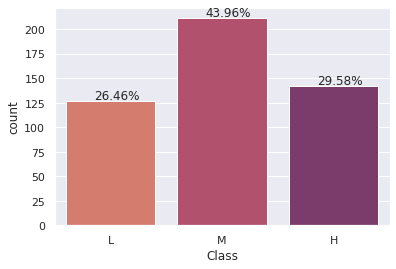

In [ ]:
#Diving deep into the class column to the determine the value counts graphically
axes = sns.countplot(x='Class', data = df, order = ['L', 'M', 'H'], palette='flare')
for i in axes.patches:
    axes.annotate('{:.2f}%'.format((i.get_height() * 100) / len(df)),(i.get_x() + 0.25, i.get_height() + 2))
plt.show()

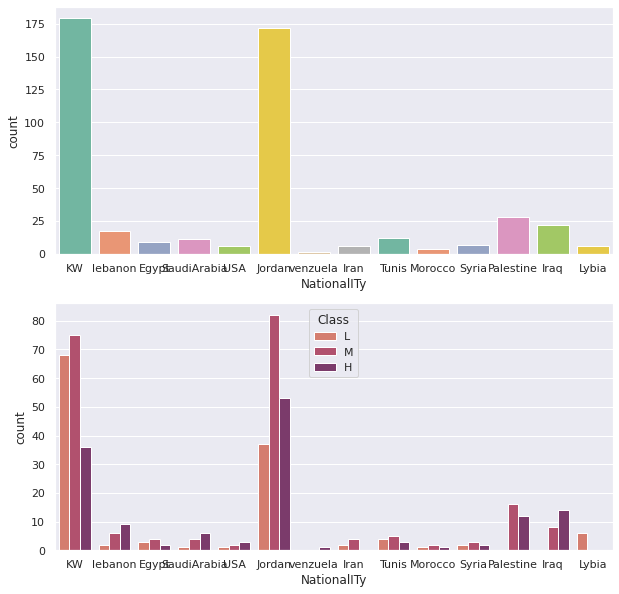

In [ ]:
# Examining the number of students from different countries and with respect to their Class categories
fig, axes = plt.subplots(2, figsize = (10,10))
sns.countplot(x = 'NationalITy', data = df, ax = axes[0], palette = 'Set2')
sns.countplot(x = 'NationalITy', data = df, ax = axes[1], palette = 'flare', hue = 'Class', hue_order = ['L', 'M', 'H'])
plt.show()

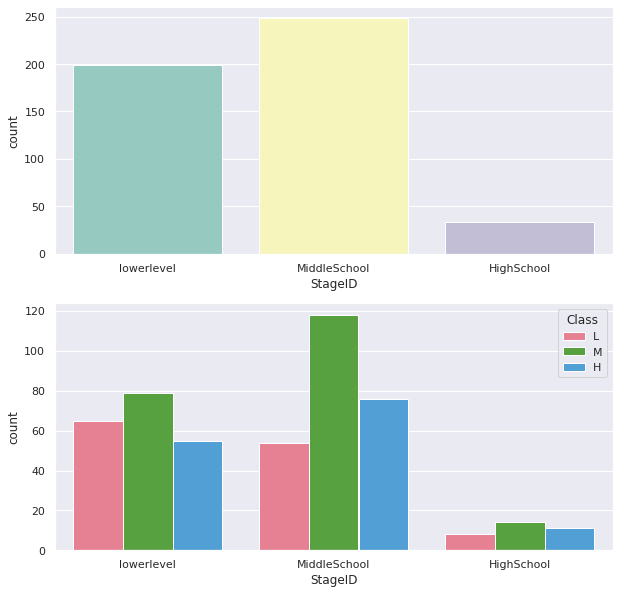

In [ ]:
# Graph of Educational level of students versus their class level
fig, axes = plt.subplots(2, figsize = (10,10))
sns.countplot(x = 'StageID', data = df, ax = axes[0], palette = 'Set3')
sns.countplot(x = 'StageID', data = df, ax = axes[1], palette = 'husl', hue = 'Class', hue_order = ['L','M','H'])
plt.show()

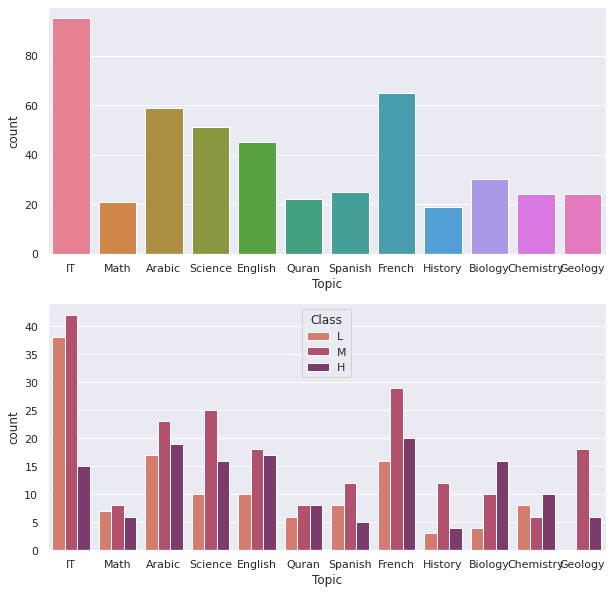

In [ ]:
# Number of Students that passed based on subjects 
fig, axes  = plt.subplots(2,figsize=(10,10))
sns.countplot(x = 'Topic', data = df, ax = axes[0], palette = 'husl')
sns.countplot(x = 'Topic', hue='Class', data = df, hue_order = ['L', 'M', 'H'], ax = axes[1], palette = 'flare')
plt.show()

In [ ]:
# Majority of students offers IT, followed by French, while History has the lowest number of students.
#it can be seen that, none of the students offering Geology failed. 
#Let’s quickly examine why Geology students did well.
df.groupby('Topic').median()

,raisedhands,VisITedResources,AnnouncementsView,Discussion
Topic,,,,
Arabic,32.0,65.0,41.0,38.0
Biology,78.5,88.5,54.0,47.0
Chemistry,79.0,84.5,47.0,30.5
English,55.0,50.0,33.0,36.0
French,35.0,80.0,23.0,21.0
Geology,80.0,82.0,68.5,60.5
History,69.0,84.0,72.0,65.0
IT,20.0,25.0,10.0,40.0
Math,28.0,15.0,19.0,40.0


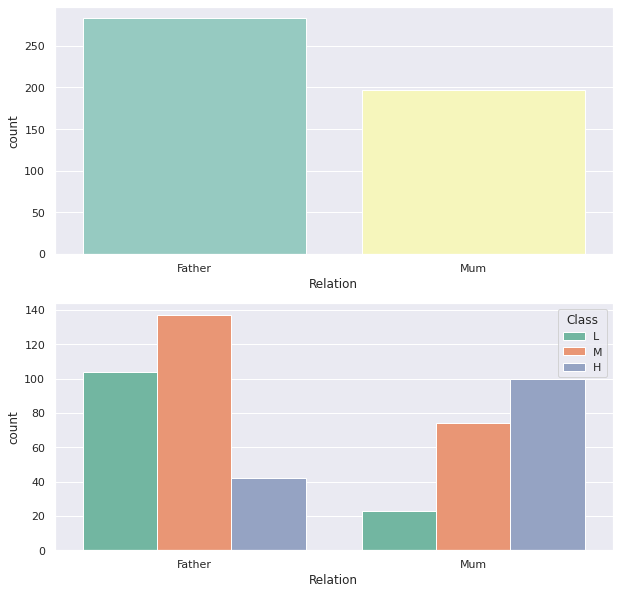

In [ ]:
# Checking to see the number of students that passed based on who the predominant parent is
fig, axes  = plt.subplots(2, figsize = (10,10))
sns.countplot(x = 'Relation', data = df, ax = axes[0], palette = 'Set3')
sns.countplot(x = 'Relation', hue = 'Class', data = df, hue_order = ['L', 'M', 'H'], ax = axes[1], palette = 'Set2')
plt.show()

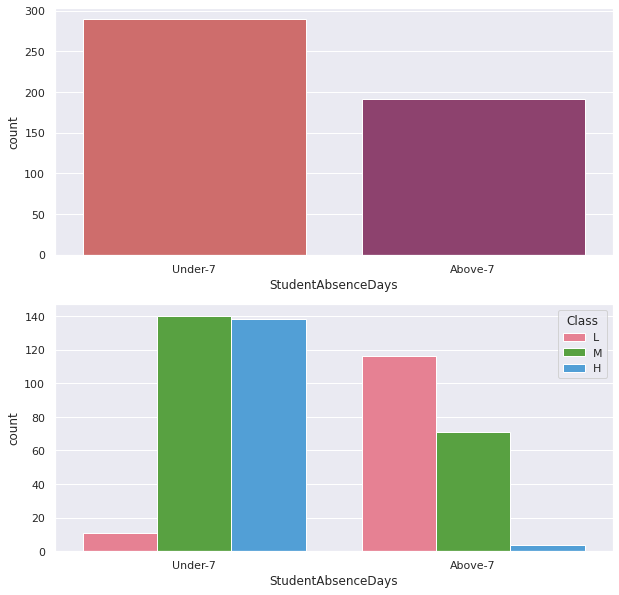

In [ ]:
# Check if StudentAbsenseDays affect grade.
fig, axes  = plt.subplots(2, figsize = (10,10))
sns.countplot(x = 'StudentAbsenceDays', data = df, order = ['Under-7', 'Above-7'], ax = axes[0], palette = 'flare')
sns.countplot(x = 'StudentAbsenceDays', hue = 'Class', data = df, order=['Under-7', 'Above-7'], hue_order = ['L', 'M', 'H'], ax = axes[1], palette = 'husl')
plt.show()

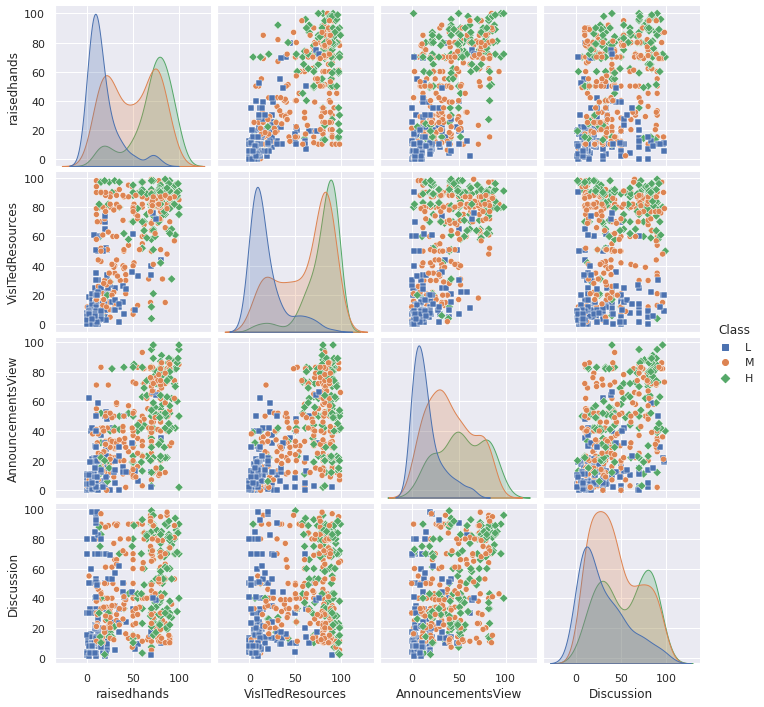

In [ ]:
# Check for other factors using pairplot
sns.pairplot(df, hue="Class", diag_kind="kde", hue_order = ['L', 'M', 'H'], markers=["o", "s", "D"])
plt.show()

In [ ]:
df.dtypes

gender                      object
NationalITy                 object
PlaceofBirth                object
StageID                     object
GradeID                     object
SectionID                   object
Topic                       object
Semester                    object
Relation                    object
raisedhands                  int64
VisITedResources             int64
AnnouncementsView            int64
Discussion                   int64
ParentAnsweringSurvey       object
ParentschoolSatisfaction    object
StudentAbsenceDays          object
Class                       object
dtype: object

In [ ]:
#Let's simplify this task. Here, we will transform this into a binary classification problem, 
#and simply predict whether the student passed or not.

#After modifying the target column, 0 will indicate the student did not pass, and 1 he/she passed.
#Subsequently, we will drop the Class column

#In the original dataset, L inidcated failed, while M and H indicated passed
#Here, L == 0 and M,H == 1
df['target'] = np.where(df['Class']=='L', 0, 1)

#Drop un-used coloums
df = df.drop(columns = 'Class')

In [ ]:
df.dtypes

gender                      object
NationalITy                 object
PlaceofBirth                object
StageID                     object
GradeID                     object
SectionID                   object
Topic                       object
Semester                    object
Relation                    object
raisedhands                  int64
VisITedResources             int64
AnnouncementsView            int64
Discussion                   int64
ParentAnsweringSurvey       object
ParentschoolSatisfaction    object
StudentAbsenceDays          object
target                       int64
dtype: object

# Preprocessing our Data

In [ ]:
## Preprocessing our Data
# Get the column type and store them in an array

numeric_columns = []
categorical_columns = []
for column in df.columns:
    if df[column].dtype == np.float64 or df[column].dtype == np.int64:
        numeric_columns.append(column)
    else:
        categorical_columns.append(column)

In [ ]:
categorical_columns

['gender',
 'NationalITy',
 'PlaceofBirth',
 'StageID',
 'GradeID',
 'SectionID',
 'Topic',
 'Semester',
 'Relation',
 'ParentAnsweringSurvey',
 'ParentschoolSatisfaction',
 'StudentAbsenceDays']

### Input pipeline

In [ ]:
# Creating a tf.data dataset from pandas dataframe

def df_to_dataset(dataset, shuffle=True, batch_size=32):
      """
      Takes in a pandas dataframe, converts it to tf.data dataset,
      shuffles, it, batchifies and prefetches it
      """
      # np.random.seed(42)
      # tf.random.set_seed(42)
      # copies the dataframe
      dataset = dataset.copy()
      labels = dataset.pop('target')
      #convert to tf.dataset
      df = tf.data.Dataset.from_tensor_slices((dict(dataset), labels))
      # Shuffle if train data
      if shuffle:
        df = df.shuffle(buffer_size=len(dataset))
      df = df.batch(batch_size)
      df = df.prefetch(batch_size)
      return df

In [ ]:
# let's split our dataset into train, valid and test
np.random.seed(42)
tf.random.set_seed(42)
train_valid, test = train_test_split(df, test_size=0.1)
train, valid = train_test_split(train_valid, test_size=0.2)

In [ ]:
train_set = df_to_dataset(train)
valid_set = df_to_dataset(valid, shuffle = False)
test_set = df_to_dataset(test, shuffle = False)

In [ ]:
[(train_features, label_batch)] = train_set.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of subejcts:', train_features['Topic'])
print('A batch of targets:', label_batch )

Every feature: ['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID', 'SectionID', 'Topic', 'Semester', 'Relation', 'raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays', 'target']
A batch of subejcts: tf.Tensor(
[b'French' b'English' b'Biology' b'French' b'Science' b'French' b'Geology'
 b'English' b'Science' b'IT' b'French' b'Math' b'IT' b'French' b'History'
 b'IT' b'Geology' b'IT' b'Geology' b'Science' b'IT' b'Math' b'French'
 b'IT' b'Science' b'IT' b'French' b'Arabic' b'English' b'Arabic' b'IT'
 b'Spanish'], shape=(32,), dtype=string)
A batch of targets: tf.Tensor([1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1], shape=(32,), dtype=int64)


In [ ]:
# function to preprocess Numeric values
# get_normalization_layer function returns a layer which applies featurewise normalization to numerical features
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()
    
    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])
    
    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)
    
    return normalizer

In [ ]:
# Let's test our function
raisedhands_col = train_features['raisedhands']
layer = get_normalization_layer('raisedhands', train_set)
layer(raisedhands_col)

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-0.7265462 ],
       [ 1.3905015 ],
       [ 0.08770286],
       [ 0.7391021 ],
       [-1.1499557 ],
       [ 0.4134025 ],
       [ 1.0648018 ],
       [-0.8893961 ],
       [-0.4985565 ],
       [-1.5407953 ],
       [-0.23799679],
       [-0.4008466 ],
       [ 0.7391021 ],
       [-0.98710597],
       [-1.2150958 ],
       [ 0.9670919 ],
       [ 0.7391021 ],
       [-1.2802356 ],
       [ 1.3579315 ],
       [ 1.3905015 ],
       [-1.5407953 ],
       [ 0.08770286],
       [ 1.0648018 ],
       [-1.4430854 ],
       [ 1.5533513 ],
       [-1.4756554 ],
       [-0.7265462 ],
       [-0.8893961 ],
       [-0.8568261 ],
       [-1.1499557 ],
       [-1.5407953 ],
       [ 0.8042421 ]], dtype=float32)>

In [ ]:
# function to preprocess our Categorical data
# get_category_encoding_layer fuction returns a layer which maps values from a vocabulary to integer indices
# and one-hot encodes the features
def get_categorical_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [ ]:
topic_col = train_features['Topic']
layer = get_categorical_encoding_layer('Topic', train_set, 'string')
layer(topic_col)

<tf.Tensor: shape=(32, 14), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
numeric_columns

['raisedhands',
 'VisITedResources',
 'AnnouncementsView',
 'Discussion',
 'target']

In [ ]:
# Preprocessing our data
numeric_columns_target = ['raisedhands',
 'VisITedResources',
 'AnnouncementsView',
 'Discussion',]
all_inputs = []
encoded_features = []

# Numeric features.
for header in numeric_columns_target:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_set)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [ ]:
# Categorical features encoded as string.

for header in categorical_columns:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_categorical_encoding_layer(header, train_set, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

## Create, Compile and Build the model

In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(300, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["accuracy"])

### Visualizing our connectivity graph

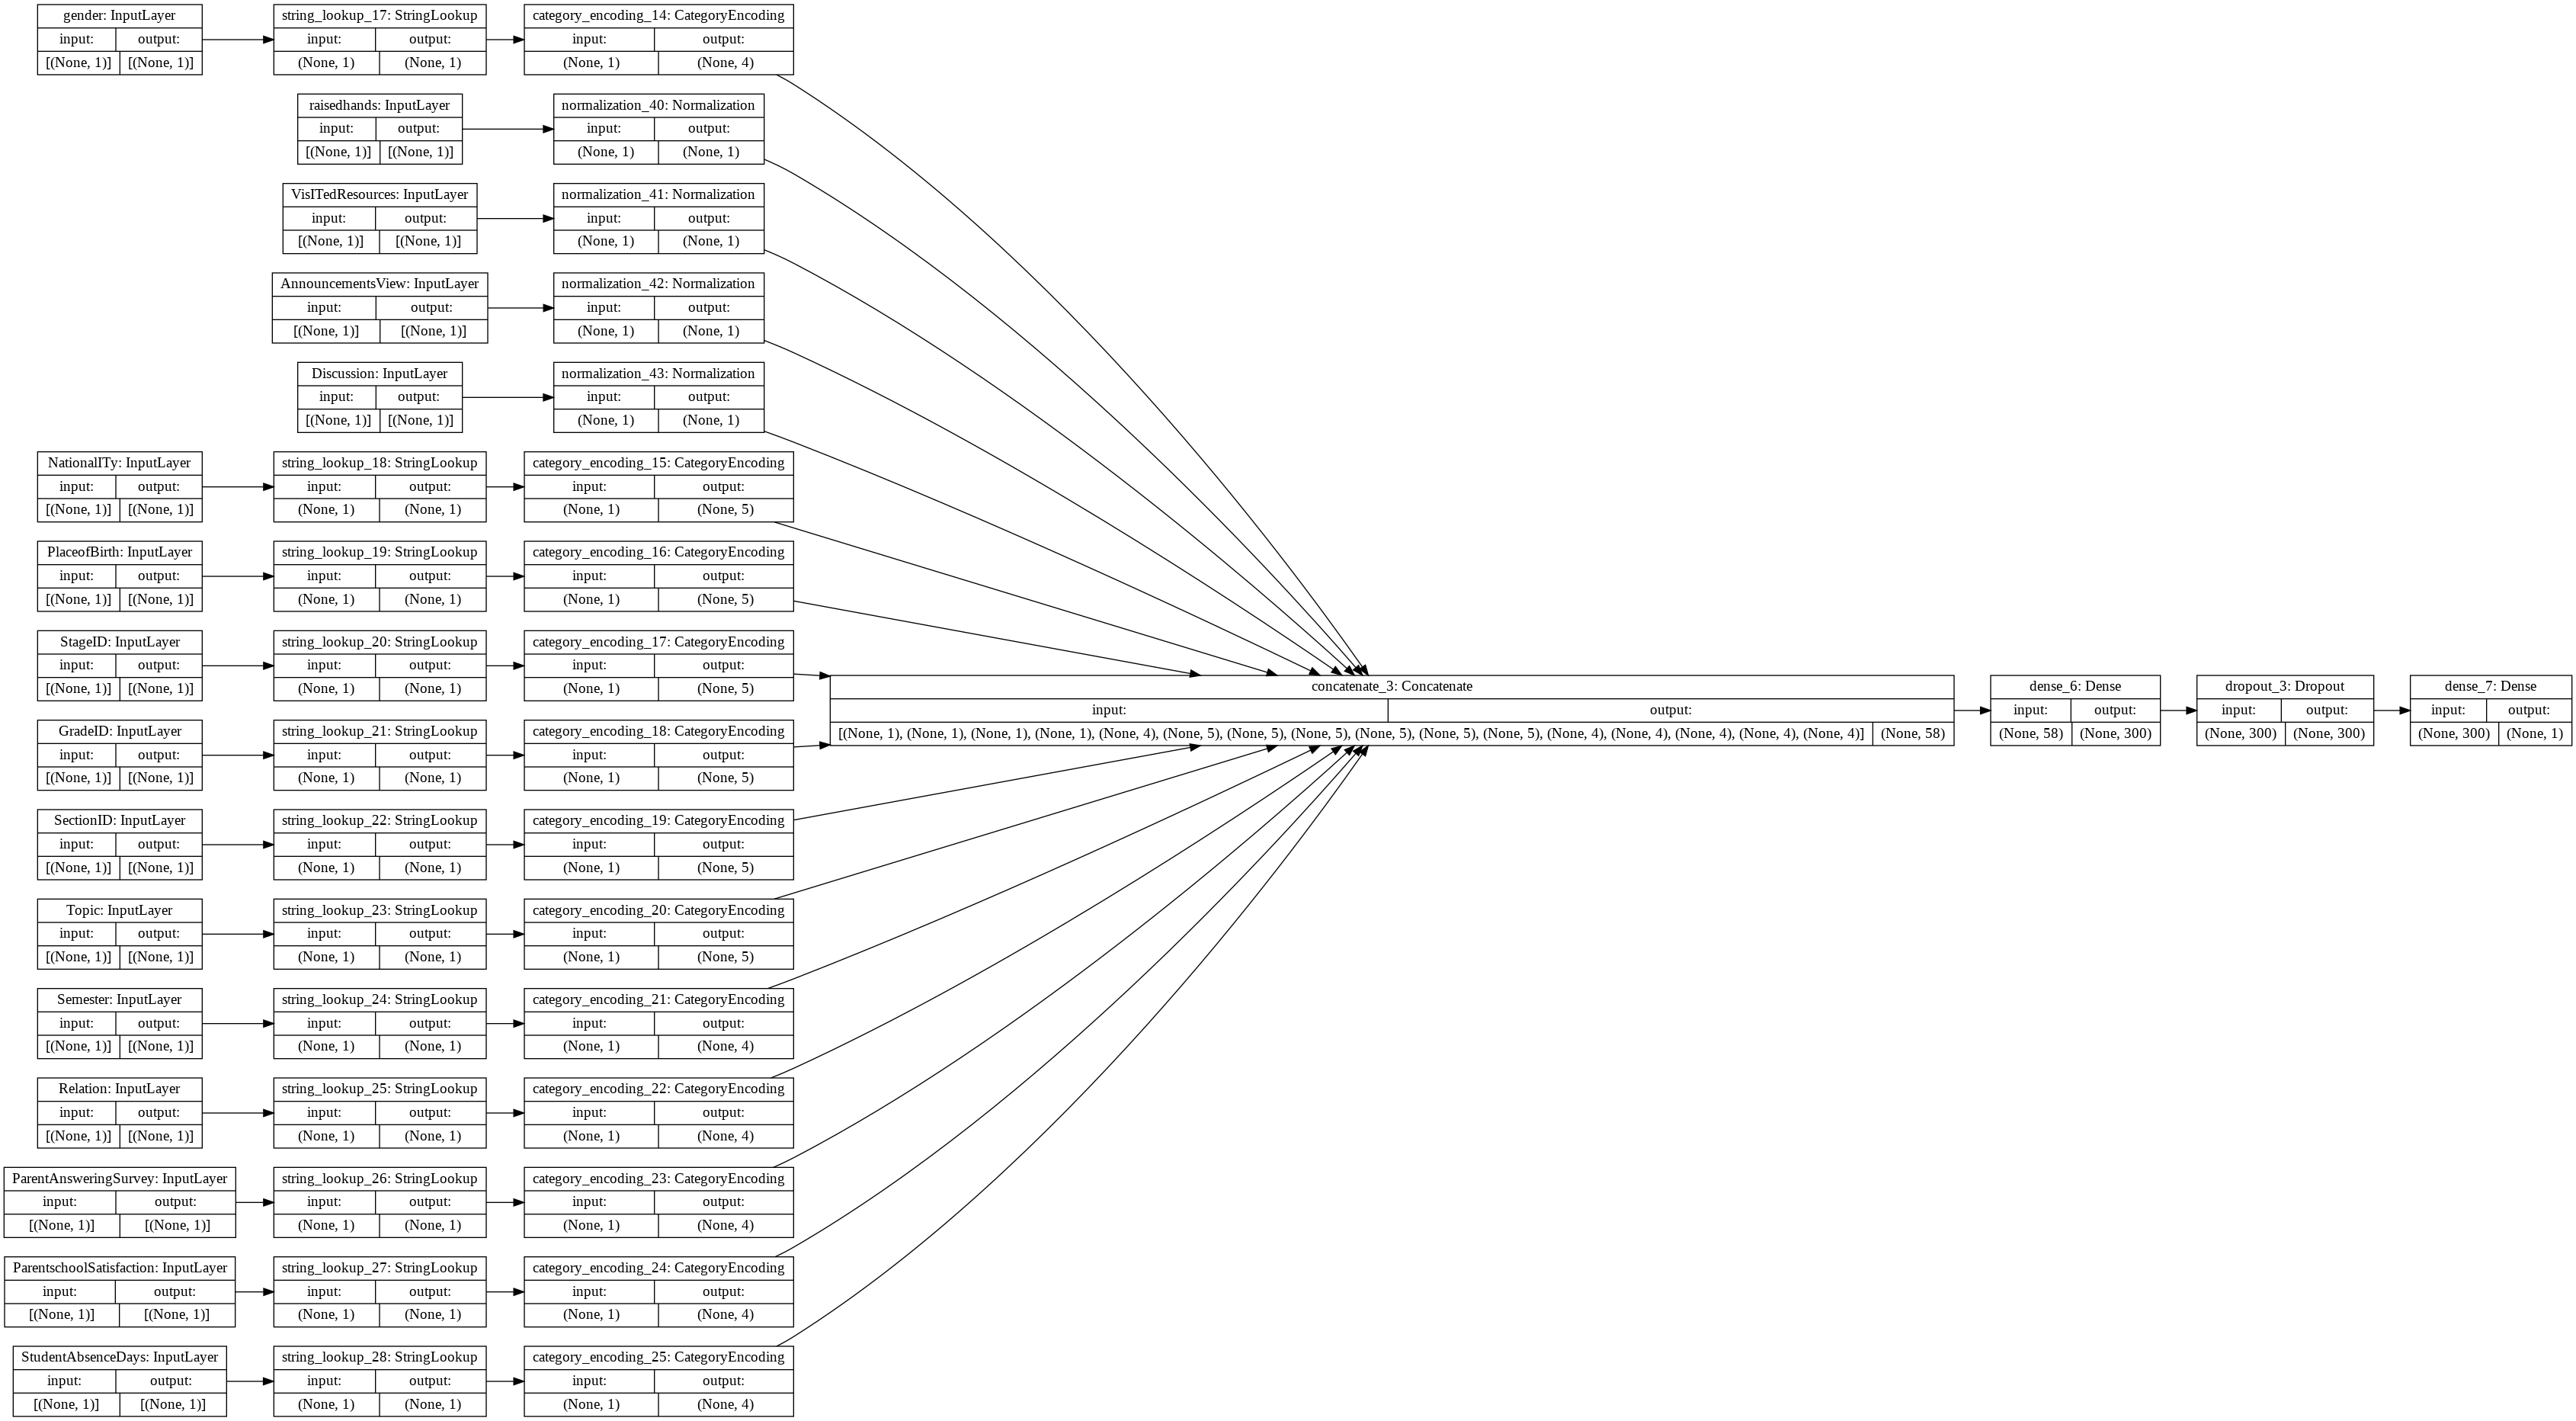

In [ ]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
# Training the model
model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
11/11 [==============================] - 2s 60ms/step - loss: 3.8242 - accuracy: 0.4819 - val_loss: 0.4571 - val_accuracy: 0.8621
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 1.4018 - accuracy: 0.8015 - val_loss: 0.1937 - val_accuracy: 0.9195
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.6403 - accuracy: 0.8698 - val_loss: 0.5375 - val_accuracy: 0.8966
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.2943 - accuracy: 0.8995 - val_loss: 0.5146 - val_accuracy: 0.9195
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.2519 - accuracy: 0.9185 - val_loss: 0.4837 - val_accuracy: 0.9195
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.4256 - accuracy: 0.9201 - val_loss: 0.4756 - val_accuracy: 0.9195
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.5838 - accuracy: 0.8996 - val_loss: 0.4768 - val_accuracy: 0.9310
Epoch 8/10
11/11 [=

In [ ]:
# Let's evaluate on our test set
loss, accuracy = model.evaluate(test_set)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 5ms/step - loss: 0.4838 - accuracy: 0.8958
Accuracy 0.8958333134651184


In [ ]:
model.save('performance_pred')
reloaded_model = tf.keras.models.load_model('performance_pred')

INFO:tensorflow:Assets written to: performance_pred/assets


In [ ]:
# Let's get a prediction for a new sample
new_sample = {
    'gender': 'F',
    'NationalITy': 'KW',               
    'PlaceofBirth': 'kuwaiT' ,               
    'StageID': 'MiddleSchool' ,       
    'GradeID': 'G-08',                    
    'SectionID': 'A',             
    'Topic': 'Chemistry',                      
    'Semester': 'F',           
    'Relation': 'Father',            
    'raisedhands': 40,                
    'VisITedResources': 20,            
    'AnnouncementsView': 14,          
    'Discussion': 20,
    'ParentAnsweringSurvey': 'Yes',       
    'ParentschoolSatisfaction': 'Good',    
    'StudentAbsenceDays': 'Under-7'          
}

In [ ]:
input_dictionary = {name: tf.convert_to_tensor([value]) for name, value in new_sample.items()}
predictions = reloaded_model.predict(input_dictionary)
probability = tf.nn.sigmoid(predictions[0])

print(
    "This particular student had a %.1f percent probability "
    "of passing." % (100 * probability)
)

This particular student had a 74.2 percent probability of passing.
